# Puts ALL WISE Astrometry reference catalogues into GAIA reference frame

<img src=https://avatars1.githubusercontent.com/u/7880370?s=200&v=4>

The WISE catalogues were produced by ../dmu16_allwise/make_wise_samples_for_stacking.csh

In the catalogue, we keep:

- The position;
- The chi^2

This astrometric correction is adapted from master list code  (dmu1_ml_XMM-LSS/1.8_SERVS.ipynb) written by Yannick Rohlly and Raphael Shirley


In [1]:
field="ELAIS-S1"

In [2]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0aab440 (Thu Mar 22 09:41:13 2018 +0000)


In [3]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

/Users/sjo/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [4]:
OUT_DIR =  os.environ.get('TMP_DIR', "../dmu16_allwise/data/")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "servs_ra"
DEC_COL = "servs_dec"

In [5]:
## I - Reading in WISE astrometric catalogue

In [6]:
wise = Table.read(f"../dmu16_allwise/data/Allwise_PSF_stack_{field}.fits")
wise_coords=SkyCoord(wise['ra'], wise['dec'])

epoch = 2009

wise[:10].show_in_notebook()

idx,ra,dec,w4mag
,deg,deg,mag
0,7.1226609,-43.939044,9.145
1,7.1226625,-43.9350588,9.099
2,7.1176465,-43.9248883,8.897
3,7.118506,-43.8739572,8.946
4,7.1225504,-43.8735403,8.439
5,7.1172113,-43.8692095,8.682
6,7.1038961,-43.8654355,9.123
7,7.1062728,-43.8632692,9.301
8,7.1218719,-43.8641356,9.076


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [7]:
#gaia = Table.read("./dmu17_XMM-LSS/data/GAIA_XMM-LSS.fits")
print(f"../../dmu0/dmu0_GAIA/data/GAIA_{field}.fits")
gaia = Table.read(f"../../dmu0/dmu0_GAIA/data/GAIA_{field}.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-S1.fits


/Users/sjo/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


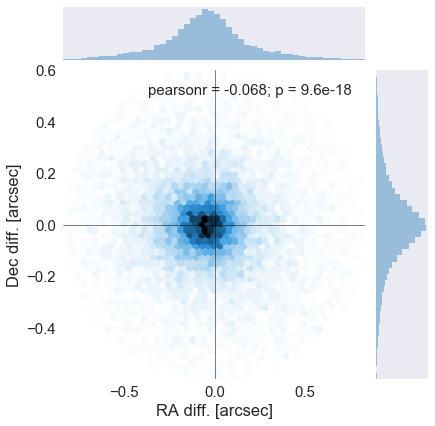

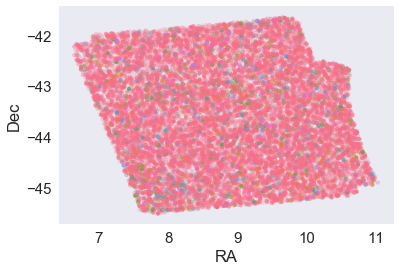

In [8]:
nb_astcor_diag_plot(wise_coords.ra, wise_coords.dec, 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [9]:
delta_ra, delta_dec =  astrometric_correction(
    wise_coords,
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.0468358587113471 arcsec
Dec correction: 0.0023535856655598764 arcsec


In [10]:
print( wise["ra"])
print(delta_ra.to(u.deg))

    ra    
   deg    
----------
 7.1226609
 7.1226625
 7.1176465
  7.118506
 7.1225504
 7.1172113
 7.1038961
 7.1062728
 7.1218719
  7.101235
       ...
10.8766444
10.8477452
10.8512846
10.8671397
10.8549303
10.8903108
10.8643672
10.8475124
10.8746479
  10.87086
Length = 131448 rows
1.3009960753151972e-05 deg


In [11]:
#wise["ra"] +=  delta_ra.to(u.deg)
wise["ra"] = wise["ra"]+ delta_ra.to(u.deg)
wise["dec"] = wise["dec"]+ delta_dec.to(u.deg)

/Users/sjo/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


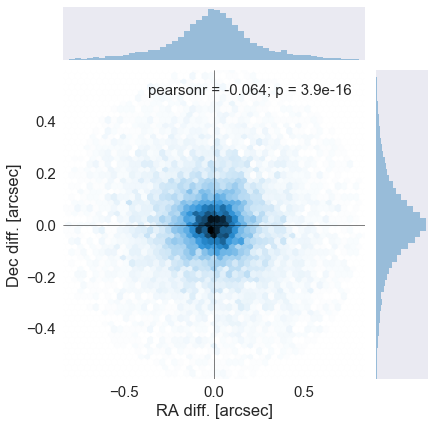

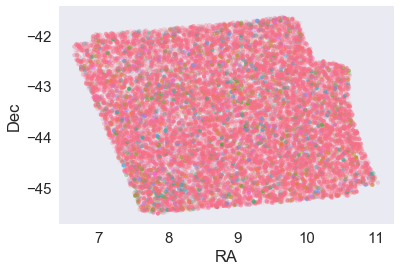

In [12]:
nb_astcor_diag_plot(wise["ra"], wise["dec"], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## V - Saving to disk

In [13]:
wise.write(f"../dmu16_allwise/data/Allwise_PSF_stack_GAIA_{field}.fits", overwrite=True)